In [1]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json

from tensorflow.keras import utils
import joblib
import pickle
import os
from tabulate import tabulate
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model, load_model_container
from modules.predict_and_prepare import pred_inverse_all, pred_and_add_durIndex, pred_all_list
from modules.eval_helpers import rmse_from_raw, mae_from_raw, mae_mse_rmse
from IPython.display import display, Markdown, Latex, Image
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [2]:
model_names = ['Gievenbeck_LSTM_Single_MSE_u128_2024-05-09']
model_alias = ['"W1"']
base_folder = os.path.join('05_models', 'test_wehr')

In [3]:
# Notebook parameters
model_names = ['Gievenbeck_LSTM_Single_MSE2024-05-16', 'Gievenbeck_LSTM_Single_MAE2024-05-16']
model_alias = ['"Loss MSE"','"Loss MAE"']
base_folder = os.path.join('05_models', 'loss_functions_compare')
# model_names = ['Gievenbeck_LSTM_Single_MSE_u128_2024-05-03']
# model_alias = ['"Units = 128"']
# base_folder = os.path.join('05_models', 'units_compare')
title = 'Vergleich Verlustfunktionen'


# export_name = 'Test_RKB' + '_' + str(date.today()) + '.ipynb'
model_names = ['Gievenbeck_RKB_LSTM_2024-05-30']
model_alias = ['"RKB BÜ"']
base_folder = os.path.join('05_models', 'test_RKB')
title = 'Test RKB'

# model_names = ['Gievenbeck_LSTM_Single_MAE_GPU2024-05-19', 'Gievenbeck_LSTM_Triple_MSE_u128_GPU_2024-05-19']
# model_alias = ['"Initial GPU"','"Final GPU"']
# base_folder = os.path.join('05_models', 'final_compare')
# title = 'Vergleich des Finalen Modells mit Grafikkarte'


In [4]:
# Parameters
model_names = ["Gievenbeck_LSTM_Triple_MSE_u128_2024-05-16", "Gievenbeck_LSTM_Triple_MSE_u128_qKnown_2024-05-18"]
model_alias = ["\"Q unbekannt\"", "\"Q bekannt\""]
base_folder = "05_models\\q_known_compare"
title = "Mit und ohne bekanntem Abfluss"


In [5]:
display(Markdown('# ' + title))
import datetime

current_time = datetime.datetime.now()
current_time_minutes = current_time.strftime("%H:%M")


current_date = datetime.date.today()
print("Erstellt am:", current_date, current_time_minutes)

# Mit und ohne bekanntem Abfluss

Erstellt am: 2024-06-05 10:39


In [6]:

# Get Model and Data
models = []
for model_name in model_names:
    model_folder = os.path.join(base_folder, model_name)
    model_container = load_model_container(model_folder, print_info=False)
    model_id = 'model_' + str(model_container['select_id'])
    # model = model_container[model_id]
    model = model_container['selected_model']
    model['cv_scores'] = model_container['cv_scores']
    comb_history = {}
    for key in model_container['selected_model']['history'].keys():
        sel_history = model_container['selected_model']['history'][key]
        prev_history = model_container[model_id]['history'][key]
        comb_history[key] = prev_history + sel_history
    model['combined_history'] = comb_history

    models.append(model)

out_unit = 'm³/s'

metrics_labels = { 'mape': 'Mittlerer absoluter prozentualer Fehler - MAPE [%]',
                  'mae': 'Mittlerer absoluter Fehler - MAE [' + out_unit + ']', 
                  'rmse': 'Wurzel der mittleren Fehlerquadratsumme - RMSE [' + out_unit + ']',
                   'mse': 'Mittlere Fehlerquadratsumme - MSE [-]',}

warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Check if test_data is same
sum_check = []
for m in models:
    sum_m = 0
    for event in m['train_data']:
        sum_m = sum_m + sum(event[1]['duration'])

    sum_check.append(sum_m)

test_same = all(x == sum_check[0] for x in sum_check)


In [8]:
# Predict and prepare all data for all given models

for m in models:
    model = m['model']
    lag = m['lag']
    delay = m['delay']
    p_steps = m['prediction_steps']
    in_vars_future = m['in_vars']
    try:
        in_vars_past = m['in_vars_past']
    except:
        in_vars_past = None
        pass
    out_vars = m['out_vars']
    if test_same == True:
        test_data = m['test_data']
    else:
        test_data = models[1]['test_data']
    train_data = m['train_data']
    # val_data = m['validation_data']
    in_scaler = m['in_scaler']
    out_scaler = m['out_scaler']

    seq_train, seq_train_trans = sequence_list(train_data, in_vars_future=in_vars_future, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps, in_vars_past=in_vars_past)
    
    # seq_val, seq_val_trans = sequence_list(val_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    # out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)
    
    seq_test, seq_test_trans = sequence_list(test_data, in_vars_future=in_vars_future, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps, in_vars_past=in_vars_past)

    # print(seq_test[0][2])
    # print(seq_test[0][2])
    # print(test_data[0][1])
    # Strukture:    pred_list[event_id][data_id][sequence_id] where data_id = 0 is event meta data, 
    #               data_id = 1 is input data, data_id = 2 is true data and data_id = 3 is predicted data
    test_pred_list = pred_and_add_durIndex(model, out_scaler, seq_test, seq_test_trans)

    train_true, train_pred = pred_inverse_all(train_data, model, in_vars_future, out_vars, in_scaler, out_scaler, lag, delay, p_steps, in_vars_past=in_vars_past)
    # val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    test_true, test_pred = pred_inverse_all(test_data, model, in_vars_future, out_vars, in_scaler, out_scaler, lag, delay, p_steps, in_vars_past=in_vars_past)
    
    train_resid = train_true - train_pred
    # val_resid = val_true - val_pred
    test_resid = test_true - test_pred
    train_resid = train_resid.flatten()
    # val_resid = val_resid.flatten()
    test_resid = test_resid.flatten()

    train_eval = mae_mse_rmse(train_true, train_pred)
    # val_eval = mae_mse_rmse(val_true, val_pred)
    test_eval = mae_mse_rmse(test_true, test_pred)
    
    m.update({'seq_test':seq_test, 'seq_test_trans':seq_test_trans,
                    'seq_train':seq_train, 'seq_train_trans':seq_train_trans,
                    # 'seq_val':seq_val, 'seq_val_trans':seq_val_trans,
                    'train_true':train_true, 'train_pred':train_pred, 
                    # 'val_true':val_true, 'val_pred':val_pred, 
                    'test_true':test_true, 'test_pred':test_pred,
                    'train_resid':train_resid, 'test_resid':test_resid,
                    # 'val_resid':val_resid, 'val_eval':val_eval, 
                    'train_eval':train_eval, 'test_eval':test_eval, 
                    'test_pred_list': test_pred_list,'print_name':model_alias[models.index(m)]})

warnings.filterwarnings('ignore')

In [9]:
# out_scaler = models[0]['out_scaler']
# model = models[0]['model']
# in_vars = models[0]['in_vars']
# out_vars = models[0]['out_vars']
# in_scaler = models[0]['in_scaler']
# out_scaler = models[0]['out_scaler']
# lag = models[0]['lag']
# delay = models[0]['delay']
# p_steps = models[0]['prediction_steps']
# test_data = models[0]['test_data']
# pred_list = pred_all_list(model, out_scaler, seq_test, seq_test_trans)
# pred_list2 = pred_and_add_durIndex(model, out_scaler, seq_test, seq_test_trans)
# true3,  pred_list3 = pred_inverse_all([test_data[0]], model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)


In [10]:
# pred_list = models[0]['test_pred_list']
# print(pred_list[0][3][10])
# print(pred_list2[0][3][10])
# print(pred_list3[10])

In [11]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


## **Modellzusammenfassungen** 

### **Gievenbeck_LSTM_Triple_MSE_u128_2024-05-16**

**Alias: "Q unbekannt"**<br><br>Gesamte Trainingszeit: 31 min

Optimierungsmethode:  adam
Verlustfunktion:  mse


**Netzaufbau:**

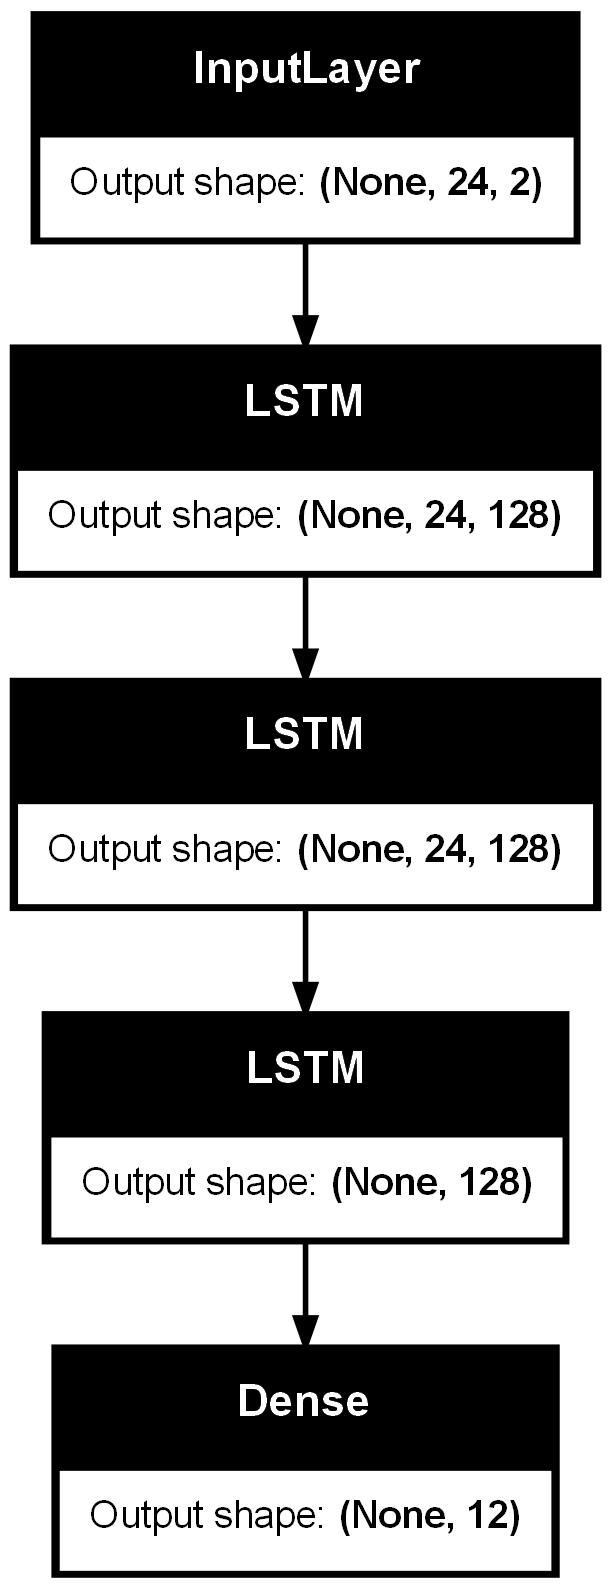

______________________________________________________________________________________________




### **Gievenbeck_LSTM_Triple_MSE_u128_qKnown_2024-05-18**

**Alias: "Q bekannt"**<br><br>Gesamte Trainingszeit: 29 min

Optimierungsmethode:  adam
Verlustfunktion:  mse


**Netzaufbau:**

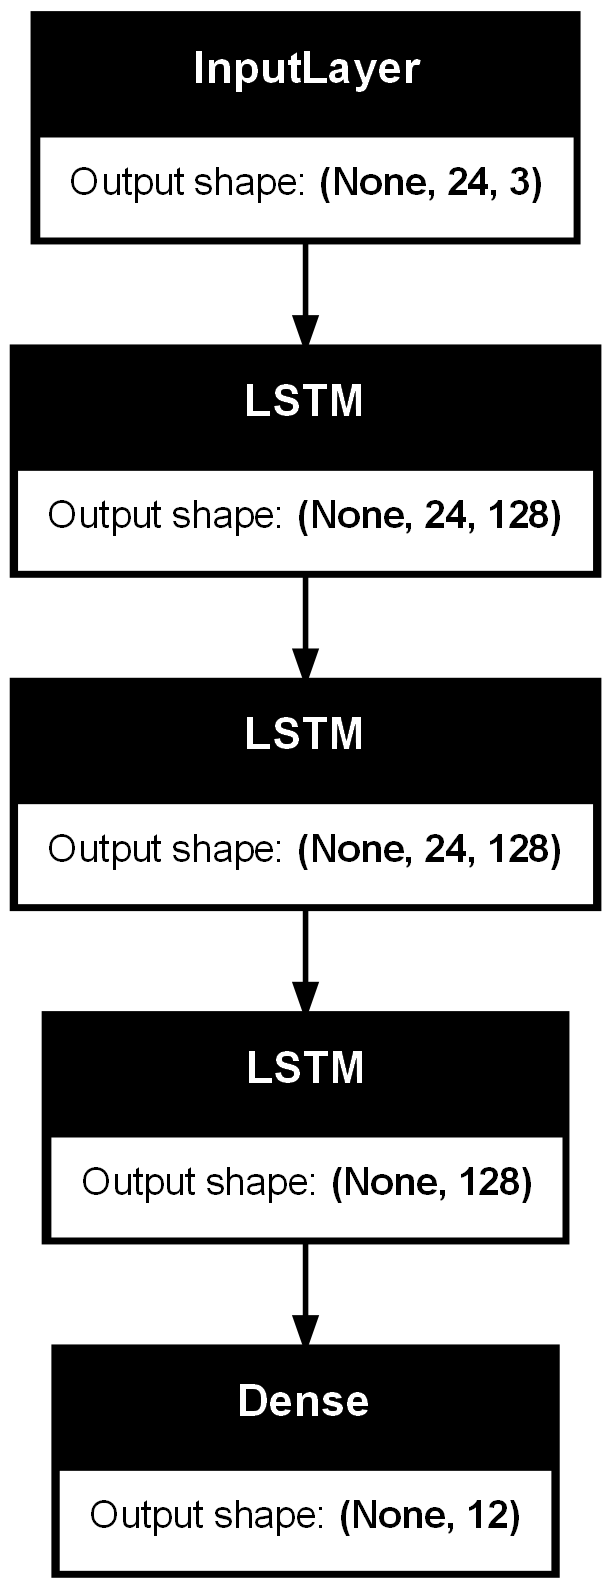

______________________________________________________________________________________________




In [12]:
#Print model summary
display(Markdown("## **Modellzusammenfassungen** "))
for m in models:
    text = "### **" + m['name'] + "**"
    display(Markdown(text))
    try:
        total_train_time = round(int(m['total_train_time']) // 60, 0)
    except:
        total_train_time = 'N/A'
        pass
    head = f"**Alias: {m['print_name']}**<br><br>Gesamte Trainingszeit: {total_train_time} min"
    display(Markdown(head))
    opti = m['model'].optimizer.get_config()
    print("Optimierungsmethode: ", opti['name'])
    print("Verlustfunktion: ", m['model'].loss)
    utils.plot_model(m['model'], to_file='model.png', show_shapes=True)
    display(Markdown('**Netzaufbau:**'))
    display(Image('model.png', width=300))
    # model_sum = m['model'].summary()
    # print(tabulate(model_sum))
    print("______________________________________________________________________________________________\n\n")

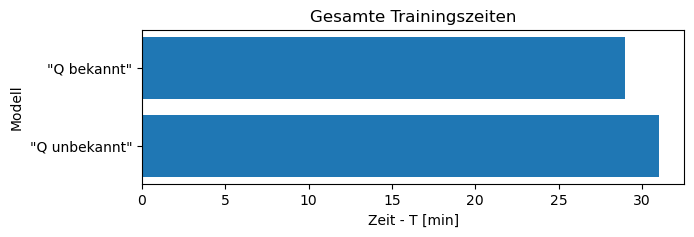

In [13]:
# Train times
import random
times = pd.DataFrame(columns=['Model', 'Train Time'])
for m in models:
    try:
        total_train_time = round(int(m['total_train_time']) // 60, 0)
    except:
        total_train_time = 'N/A'
        pass
    new_row = pd.DataFrame([{'Model': m['print_name'], 'Train Time': total_train_time }])
    times = pd.concat([times,new_row], ignore_index=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 2))
plt.barh(times['Model'], times['Train Time'])

# Add labels and title
plt.xlabel('Zeit - T [min]')
plt.ylabel('Modell')
plt.title('Gesamte Trainingszeiten')

# Display the plot
plt.show()

### Datenaufteilung

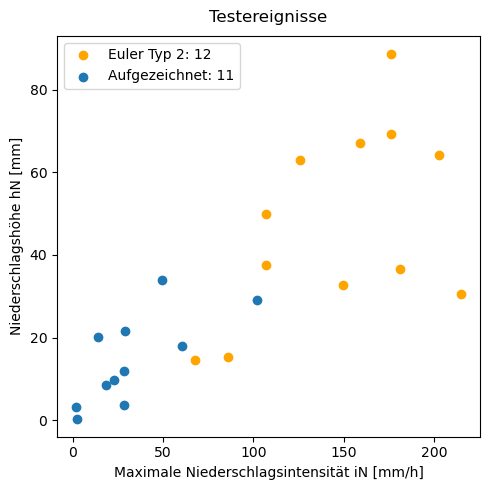

In [14]:
# Extract total precipitation and max intensity from seq_test
seq_test_trans = models[0]['seq_test_trans']
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(5, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='orange', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('Maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


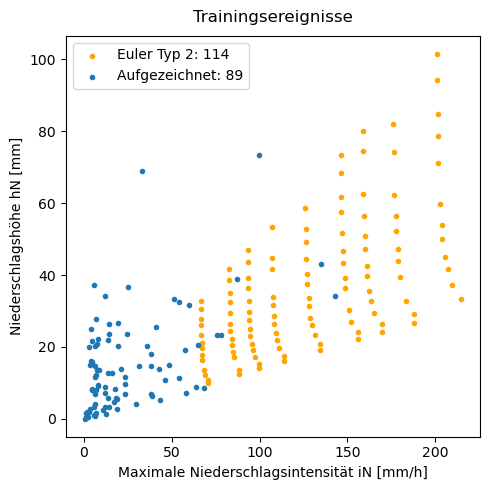

In [15]:
m = models[0]
train_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']
train_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Euler Typ 2']

train_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
train_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_train_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

# val_e2_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']
# val_e2_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Euler Typ 2']

# val_measured_precip = [obj[0]['total precipitation'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']
# val_measured_intensity = [obj[0]['max intensity'] for obj in m['seq_val_trans'] if obj[0]['event type'] == 'Aufgezeichnet']

train_precip = [obj[0]['total precipitation'] for obj in seq_train_trans]
train_intensity = [obj[0]['max intensity'] for obj in seq_train_trans]

# val_precip = [obj[0]['total precipitation'] for obj in seq_val_trans]
# val_intensity = [obj[0]['max intensity'] for obj in seq_val_trans]

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(5, 5))
ax2.scatter(train_e2_intensity, train_e2_precip, marker='.', color='orange', label='Sample')
ax2.scatter(train_measured_intensity, train_measured_precip, marker='.', label='Events')
# ax2.plot( val_e2_intensity, val_e2_precip,'o', color='Black', label='Sample')
# ax2.scatter(val_measured_precip, val_measured_intensity, marker='x', color='Black', label='Events')

ax2.set_xlabel('Maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Trainingsereignisse', pad=10)
# ax2.legend(labels=['Training (Euler Typ 2): {}'.format(len(train_e2_intensity)), 'Training (Aufgezeichnet): {}'.format(len(train_measured_precip)), 
#                 'Validierung (Euler Typ 2): {}'.format(len(val_e2_precip)), 'Validierung (Aufgezeichnet): {}'.format(len(val_measured_intensity))])
ax2.legend(labels=['Euler Typ 2: {}'.format(len(train_e2_intensity)), 'Aufgezeichnet: {}'.format(len(train_measured_precip))])
plt.tight_layout()

### Gesamtauswertung der Modelle

**Auswertung der Metriken bei der Kreuzvalidierung**

Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Der Boxplot beinhaltet die Metriken der Kreuzvalidierung für die Trainings- und Validierungsdaten.

Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.

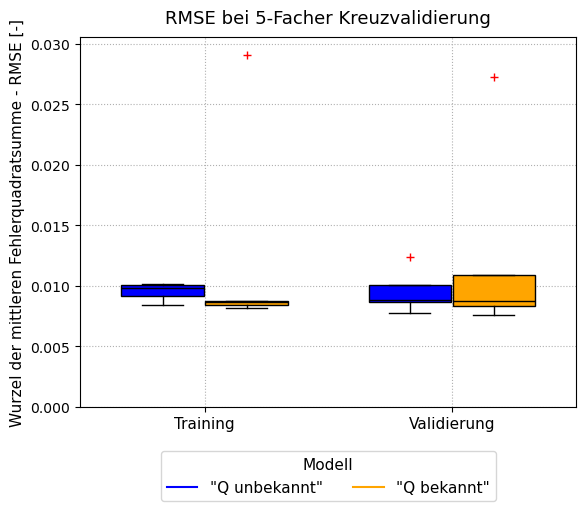

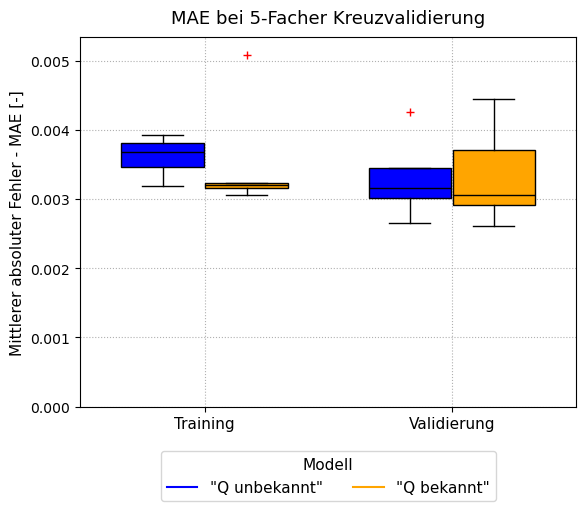

In [16]:
# cross validation results
display(Markdown('**Auswertung der Metriken bei der Kreuzvalidierung**'))
display(Markdown('Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Der Boxplot beinhaltet die Metriken der Kreuzvalidierung für die Trainings- und Validierungsdaten.'))
display(Markdown('Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.'))

colors = ['blue','orange', 'green', 'pink', 'lightblue', 'lightgreen', 'violet']

if 'mse' in models[0]['cv_scores'].columns:
    metrics = ['mse', 'mae']
else:
    metrics = ['loss']
metrics = ['mse', 'mae']
metrics_k_fold = {'mae': 'Mittlerer absoluter Fehler - MAE [-]', 
                  'mse': 'Wurzel der mittleren Fehlerquadratsumme - RMSE [-]',}


# metric_name = 'mse'
for metric_name in metrics:
    if metric_name == 'mse':
        metric_upper = 'RMSE'
    else:
        metric_upper = metric_name.upper()
    data_groups = []
    model_names = []
    for m in models:
        model_names.append(m['print_name'])
        train_result = m['cv_scores'][metric_name]
        val_result = m['cv_scores']['val_'+ metric_name]
        if metric_name == 'mse':
            train_result = np.sqrt(train_result)
            val_result = np.sqrt(val_result)


        new_data = [train_result, val_result]
        data_groups.append(new_data)


    # --- Labels for your data:
    labels_list = ['Training','Validierung']
    width       = 1/len(labels_list)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(new_data)) ]

    symbol      = 'r+'
    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])

    ax = plt.gca()
    ax.set_ylim(ymin,ymax)

    ax.grid(True, linestyle='dotted')
    ax.set_axisbelow(True)

    # plt.xlabel('X axis label')
    plt.ylabel(metrics_k_fold[metric_name], fontsize=11)
    plt.title('title')

    space = len(data_groups)/2
    offset = len(data_groups)/2


    # --- Offset the positions per group:

    group_positions = []
    for num, dg in enumerate(data_groups):    
        _off = (0 - space + (0.5+num))
        group_positions.append([x+_off*(width+0.01) for x in xlocations])

    for dg, pos, c, name in zip(data_groups, group_positions, colors, model_names):
        boxes = ax.boxplot(dg, 
                    sym=symbol,
                    labels=['']*len(labels_list),
        #            labels=labels_list,
                    positions=pos, 
                    widths=width, 
                    boxprops=dict(facecolor=c),
        #             capprops=dict(color=c),
        #            whiskerprops=dict(color=c),
        #            flierprops=dict(color=c, markeredgecolor=c),                       
                    medianprops=dict(color='black'),
        #           notch=False,  
        #           vert=True, 
        #           whis=1.5,
        #           bootstrap=None, 
        #           usermedians=None, 
        #           conf_intervals=None,
                    patch_artist=True,
                    )
        plt.plot([], c=c, label=name)
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modell', fontsize=11, title_fontsize=11)
    ax.set_xticks( xlocations )
    ax.set_xticklabels( labels_list, rotation=0 , fontsize=11)
    ax.set_title(metric_upper + ' bei 5-Facher Kreuzvalidierung', pad=10, fontsize=13)
    ymax = max([val for dg in data_groups for data in dg for val in data])
    ymax = ymax + ymax * 0.05
    ax.set_ylim(0, ymax)


    plt.show()

In [17]:
# # cross validation results
# display(Markdown('**Auswertung des durchschnittlichen Metriken der Kreuzvalidierung**'))
# display(Markdown('Bei jeder Modellerstellung werden die Daten zufällig in Trainings- und Validierungsdaten aufgeteilt. Die Balken zeigen die durchschnittlichen Metriken der Kreuzvalidierung für die Trainings- und Validierungsdaten.'))
# display(Markdown('Hierbei ist zu beachten, dass diese Metrik vor der Datentransformation berechnet wurde und somit nur in diesem Verlgleich aussagekraft habe und mit nachfolgenden Metriken nicht vergleichbar ist.'))

# if 'mse' in models[0]['cv_scores'].columns:
#     metrics = ['mse', 'mae']
# else:
#     metrics = ['loss']
# metrics = ['mse', 'mae']
# metrics_k_fold = {'mae': 'Mittlerer absoluter Fehler - MAE [-]', 
#                   'mse': 'Wurzel der mittleren Fehlerquadratsumme - RMSE [-]',}

# for metric_name in metrics:
#     metric = pd.DataFrame()
#     metric_table = pd.DataFrame()
#     if metric_name == 'mse':
#         metric_upper = 'RMSE'
#     else:
#         metric_upper = metric_name.upper()
#     for m in models:
#         name = m['print_name']
#         train_result = m['cv_scores'][metric_name].mean()
#         if metric_name == 'mse':
#             train_result = np.sqrt(train_result)
#         val_result = m['cv_scores']['val_' + metric_name].mean()
#         if metric_name == 'mse':
#             val_result = np.sqrt(val_result)
#         new_row = pd.DataFrame({'Modell':name,'Training': train_result, 'Validierung': val_result}, index=[0])
#         if val_result < 1 or train_result < 1:
#             metric = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)
#             metric_table = pd.concat([metric_table, pd.DataFrame(new_row)] , ignore_index=True)
#         else:
#             metric_table = pd.concat([metric_table, pd.DataFrame(new_row)] , ignore_index=True)

#     ax = metric.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False, figsize=(5,4))
#     ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modell')
#     ax.set_ylabel(metrics_k_fold[metric_name])

#     ax.set_title('Durchschnittl. '+ metric_upper + ' der Kreuzvalidierung', pad=10)
#     display(Markdown('Durchschnittlicher ' + metric_upper + ':'))
#     print(tabulate(round(metric_table, 5), headers='keys', tablefmt='pretty', showindex=False))
#     # Show the plot
#     plt.show()

### Lernkurven

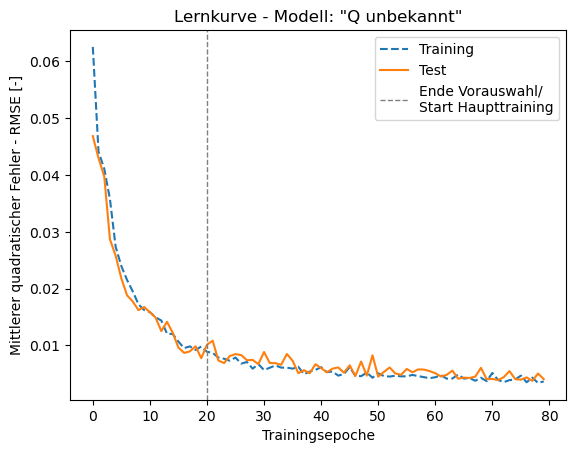

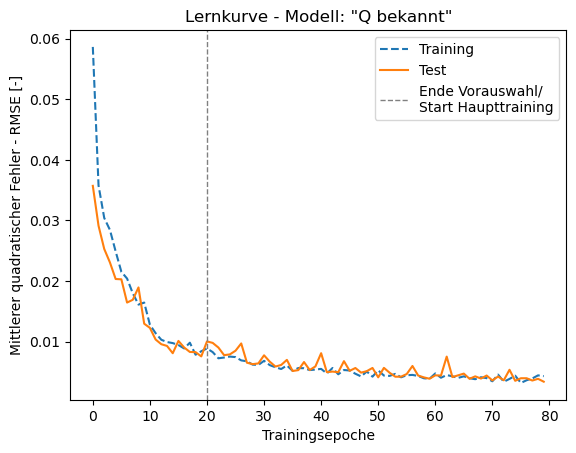

In [18]:
# Plot the learning curve
display(Markdown('### Lernkurven'))
metrics = ['mse', 'mae']
for m in models:
    metric = 'loss'
    train_switch = len(m['combined_history'][metric]) - len(m['history'][metric])
    pyplot.plot(np.sqrt(m['combined_history']['loss']), '--', label='Training')
    if 'val_'+metric in m['combined_history']:
        pyplot.plot(np.sqrt(m['combined_history']['val_'+metric]), label='Test')
    pyplot.axvline(x=train_switch, color='grey', linestyle='--', linewidth=1, label='Ende Vorauswahl/\nStart Haupttraining')
    pyplot.xlabel('Trainingsepoche')
    pyplot.ylabel('Mittlerer quadratischer Fehler - RMSE [-]')
    pyplot.legend()
    pyplot.title('Lernkurve - Modell: ' + m['print_name'])
    pyplot.show()

**Auswertung nach RMSE**

+---------------+----------+--------+
|    Modell     | Training |  Test  |
+---------------+----------+--------+
| "Q unbekannt" |  0.0078  | 0.0099 |
|  "Q bekannt"  |  0.0068  | 0.0081 |
+---------------+----------+--------+


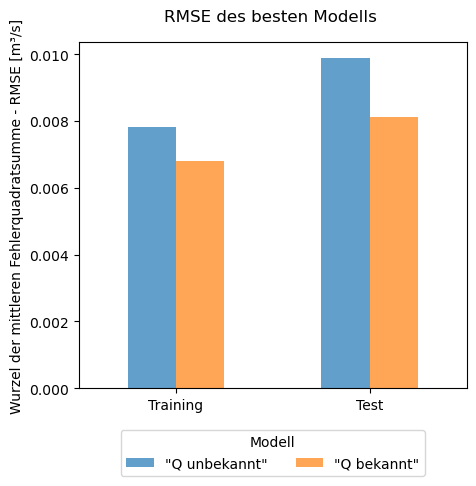

**Auswertung nach MAE**

+---------------+----------+--------+
|    Modell     | Training |  Test  |
+---------------+----------+--------+
| "Q unbekannt" |  0.003   | 0.0038 |
|  "Q bekannt"  |  0.0027  | 0.0033 |
+---------------+----------+--------+


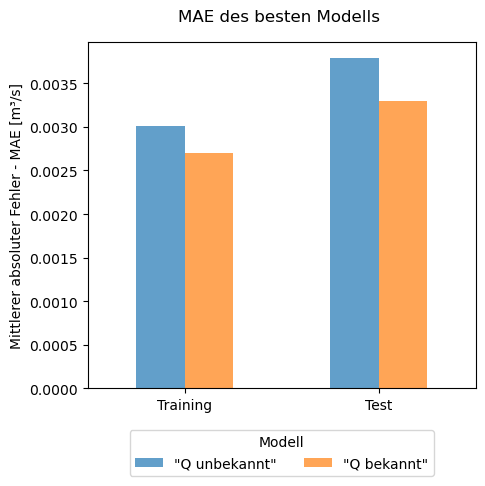

In [19]:
# Vergleich RMSE
metric_names = ('rmse', 'mae')
for m_name in metric_names:
    metrics = pd.DataFrame()
    name_upper = m_name.upper()
    for m in models:
        name = m['print_name']
        train_metric = m['train_eval'][m_name]
        # val_metric = m['val_eval'][m_name]
        test_metric = m['test_eval'][m_name]
        new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Test': test_metric}, index=[0])
        # new_row = pd.DataFrame({'Modell':name,'Training': train_metric, 'Validierung': val_metric, 'Test': test_metric}, index=[0])
        metrics = pd.concat([metrics, pd.DataFrame(new_row)] , ignore_index=True)

    ax = metrics.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False, figsize=(5,4.5))
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, title='Modell')
    ax.set_ylabel(metrics_labels[m_name])

    ax.set_title(name_upper + ' des besten Modells ', pad=15)

    # print(name_upper)
    display(Markdown('**Auswertung nach '+name_upper+'**'))
    print(tabulate(round(metrics, 4), headers='keys', tablefmt='pretty', showindex=False))

    # Show the plot
    plt.show()

### Modellauswertung nach Größenklassen der Ausgabewerte

In [20]:
import warnings
# Metrics based on Output magnitude
magnitude_metrics = []

for m in models:

    test_true_flattened = m['test_true'].flatten()
    test_pred_flattened = m['test_pred'].flatten()

    test_stack_flat = np.column_stack((test_true_flattened, test_pred_flattened))
    test_stack_flat = test_stack_flat[test_stack_flat[:, 0] != 0]
    test_stack_flat = pd.DataFrame(test_stack_flat, columns=['True', 'Pred'])

    # Get the value range of test_stack['True']
    value_range = np.ptp(test_stack_flat['True'])

    # Split the value range into 4 equal ranges
    ranges = np.linspace(0, np.max(test_stack_flat['True']), num=11)


    test_stack_flat['Bins'] = pd.cut(test_stack_flat['True'], bins=ranges, labels=False, include_lowest=True)
    ranges = np.round(ranges, 2)

    # Get unique bins
    unique_bins = test_stack_flat['Bins'].unique()
    unique_bins = sorted(unique_bins)



    # Create a list to store the datasets
    bins = []

    # Iterate over each unique bin
    for bin_num in unique_bins:
        # Filter the dataframe for the current bin
        bin_data = test_stack_flat[test_stack_flat['Bins'] == bin_num].copy()
        
        # Append the filtered dataset to the list
        bins.append(bin_data)

    metrics = pd.DataFrame([])
    metrics = pd.DataFrame(columns=['Bin', 'MSE','RMSE', 'MAE', 'MAPE', 'start', 'end', 'False_0', 'n'])
    i = 0
    for bin in bins:
        mse = np.mean((bin['True'] - bin['Pred'])**2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(bin['True'] - bin['Pred']))
        mape = np.mean(np.abs((bin['True'] - bin['Pred']) / bin['True'])) * 100
        
        bin_start = ranges[i]
        bin_end = ranges[i+1]
        False_0 = len(bin[bin['Pred'] == 0])
        n = len(bin)

        new_row = pd.DataFrame({'Bin':i, 'MSE':mse,'RMSE':rmse, 'MAE':mae, 'MAPE':mape, 'start':bin_start, 'end':bin_end, 'False_0': False_0, 'n':n}, index=[0])

        i +=1
        
        metrics = pd.concat([metrics,new_row], ignore_index=True)
        
    
    magnitude_metrics.append(metrics)



i = 0
for metric in magnitude_metrics:
    metric[['MSE', 'MAE', 'RMSE']] = metric[['MSE', 'MAE', 'RMSE']].round(4)
    metric[['MAPE']] = metric[['MAPE']].round(2)
    print('Modell: ' + models[i]['print_name'])
    print(tabulate(metric, headers='keys', tablefmt='pretty', showindex=False))
    i += 1

warnings.filterwarnings("ignore")


Modell: "Q unbekannt"
+-----+--------+--------+--------+------+-------+------+---------+------+
| Bin |  MSE   |  RMSE  |  MAE   | MAPE | start | end  | False_0 |  n   |
+-----+--------+--------+--------+------+-------+------+---------+------+
|  0  | 0.0001 | 0.0096 | 0.0054 | 9.29 |  0.0  | 0.24 |   49    | 8715 |
|  1  | 0.0005 | 0.0223 | 0.0167 | 5.18 | 0.24  | 0.49 |    0    | 519  |
|  2  | 0.0012 | 0.035  | 0.0251 | 4.14 | 0.49  | 0.73 |    0    | 184  |
|  3  | 0.0017 | 0.0411 | 0.0308 | 3.68 | 0.73  | 0.97 |    0    |  85  |
|  4  | 0.0011 | 0.0333 | 0.0233 | 2.1  | 0.97  | 1.22 |    0    | 107  |
|  5  | 0.0003 | 0.0172 | 0.0135 | 1.04 | 1.22  | 1.46 |    0    |  43  |
|  6  | 0.0029 | 0.0539 | 0.0389 | 2.55 | 1.46  | 1.7  |    0    |  26  |
|  7  | 0.0019 | 0.0433 | 0.0298 | 1.64 |  1.7  | 1.95 |    0    |  54  |
|  8  | 0.0015 | 0.0383 | 0.0316 | 1.53 | 1.95  | 2.19 |    0    |  63  |
|  9  | 0.0009 | 0.0295 | 0.0212 | 0.91 | 2.19  | 2.43 |    0    |  79  |
+-----+--------+

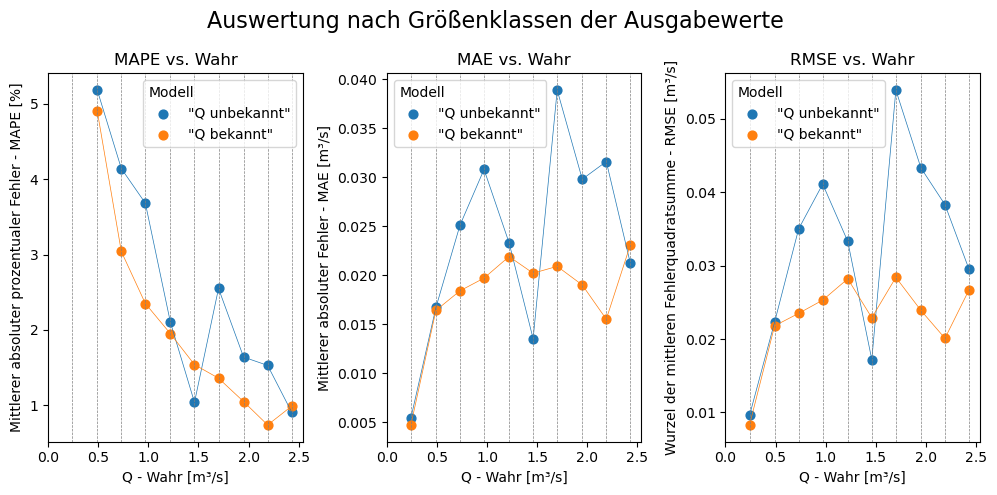

In [21]:
metrics = ('MAPE', 'MAE', 'RMSE')


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

j = 0
for metric in metrics:
    i = 0
    for m in magnitude_metrics:
        if metric == 'MAPE':
            x = m['end'].iloc[1:]
            y = m[metric].iloc[1:]
        else:
            x = m['end']
            y = m[metric]
        
        # print(m)
        axs[j].scatter(x, y, label = models[i]['print_name'], marker='o', s=40)
        axs[j].plot(x, y, linewidth=0.5)
        i += 1
    axs[j].set_xlabel('Q - Wahr ['+ out_unit + ']')
    axs[j].set_ylabel(metrics_labels[metric.lower()])
    for border in magnitude_metrics[0]['end']:
        axs[j].axvline(x=border, color = 'grey', linestyle='--', linewidth=0.5)
    axs[j].set_title(metric + ' vs. Wahr')
    axs[j].set_xlim(0,None)

    axs[j].legend(title="Modell", fancybox=True)._legend_box.align = "left"
    
    j += 1

fig.suptitle('Auswertung nach Größenklassen der Ausgabewerte', fontsize=16)
plt.tight_layout()
plt.show()

### Residuen

In [22]:
# # Plot True vs. Predicted
# cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
# rows = ['{}'.format(row) for row in ['Training', 'Test']]
# # rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

# m_trues = []
# m_preds = []
# mins =[]
# maxs = []

# for m in models:
#     # Calculate the regression line using polynomial fit
#     train_pred_flat = m['train_pred'].flatten()
#     train_true_flat = m['train_true'].flatten()
#     # val_pred_flat = m['val_pred'].flatten()
#     # val_true_flat = m['val_true'].flatten()
#     test_pred_flat = m['test_pred'].flatten()
#     test_true_flat = m['test_true'].flatten()
#     names = ['Training', 'Test']
#     preds = [train_pred_flat, test_pred_flat]
#     trues = [train_true_flat, test_true_flat]
#     # names = ['Training', 'Validierung', 'Test']
#     # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
#     # trues = [train_true_flat, val_true_flat, test_true_flat]
#     min_value = min(min(r) for r in preds)
#     max_value = max(max(r) for r in preds)
#     mins.append(min_value)
#     maxs.append(max_value)
#     m_preds.append(preds)
#     m_trues.append(trues)

# min_val = min(mins)
# max_val = max(maxs)
# regression_range = np.linspace(min_val, max_val, 100)

# # Plot if only one model is given
# if len(m_preds) == 1:
#     for j in range(len(m_preds)):
#         fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#         for i in range(len(m_preds[j])):
#             # Create a figure and subplots

#             reg_line = np.polyfit(m_preds[j][i], m_trues[j][i], 2)
#             reg_line_fn = np.poly1d(reg_line)
#             # Plot train_pred/train_resid
#             axs[i].scatter(m_preds[j][i], m_trues[j][i], marker ='.', s= 2, label = 'Wertepaare')
#             axs[i].set_title(names[i])
#             axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
#             axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
#             # Plot the average line
#             axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
#             # Plot the regression line
#             axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
#             axs[i].legend(frameon=False)
#             axs[i].set_ylim(min_val, max_val)
#             axs[i].legend()

#     fig.suptitle('Wahr vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
#     plt.show()

# # Plot if more than one model are given
# else:
#     for j in range(len(m_preds[0])):
#         fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))

#         for i in range(len(m_preds)):
#             try:
#                 # Create a figure and subplots

#                 reg_line = np.polyfit(m_preds[i][j], m_trues[i][j], 2)
#                 reg_line_fn = np.poly1d(reg_line)
#                 # Plot train_pred/train_resid
#                 axs[i].scatter(m_preds[i][j], m_trues[i][j], marker ='.', s= 2, label = 'Wertepaare')
#                 axs[i].set_title(cols[i])
#                 axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
#                 axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
#                 # Plot the average line
#                 axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
#                 # Plot the regression line
#                 axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
#                 axs[i].legend(frameon=False)
#                 axs[i].set_ylim(min_val, max_val)
#                 axs[i].legend()
#             except:
#                 pass
#         fig.suptitle('Wahr vs. Vorhergesagt - ' + rows[j], fontsize=16)
#         fig.tight_layout()
#         plt.show()

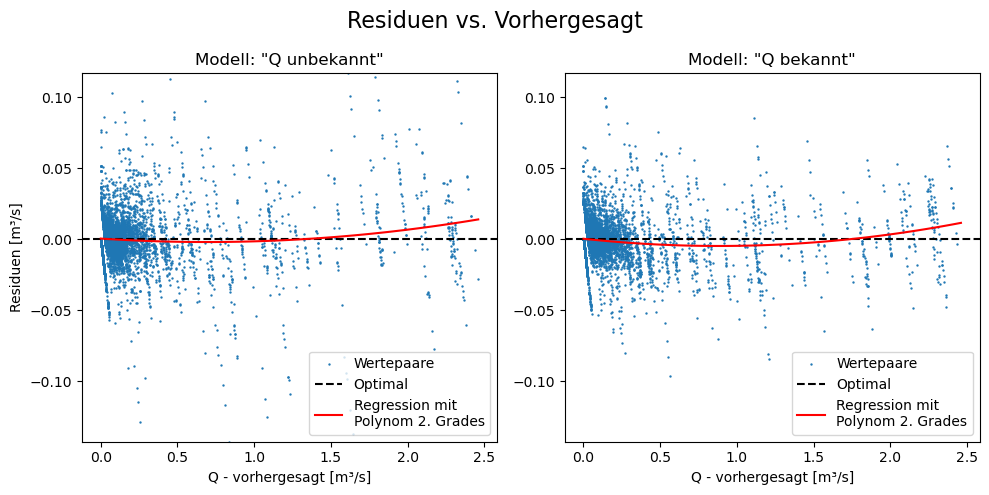

In [23]:
cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
rows = ['{}'.format(row) for row in ['Test']]
# rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

m_resids = []
m_preds = []
mins =[]
maxs = []
maxs_preds = []
for m in models:
    # Calculate the regression line using polynomial fit
    # train_pred_flat = m['train_pred'].flatten()
    # train_resid = m['train_resid']
    # val_pred_flat = m['val_pred'].flatten()
    # val_resid = m['val_resid']
    test_pred_flat = m['test_pred'].flatten()
    test_resid = m['test_resid']
    # names = ['Training', 'Test']
    # preds = [train_pred_flat, test_pred_flat]
    # resids = [train_resid, test_resid]
    names = ['Datensatz: Test']
    preds = [test_pred_flat]
    resids = [test_resid]
    # names = ['Training', 'Validierung', 'Test']
    # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    # resids = [train_resid, val_resid, test_resid]
    min_value = min(min(r) for r in resids)
    max_value = max(max(r) for r in resids)
    max_pred = max(max(p) for p in preds)
    mins.append(min_value)
    maxs.append(max_value)
    maxs_preds.append(max_pred)
    m_preds.append(preds)
    m_resids.append(resids)
max_pred_val = max(maxs_preds)
min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(0, max_pred_val, 100)



# Plot if only one model is given
if len(m_preds) == 1:
    for j in range(len(m_preds)):
        fig, axs = plt.subplots(figsize=(5, 5))

        for i in range(len(m_preds[j])):
            try:
                # Create a figure and subplots
                
                reg_line = np.polyfit(m_preds[j][i], m_resids[j][i], 2)
                reg_line_fn = np.poly1d(reg_line)
                # Plot train_pred/train_resid
                axs.scatter(m_preds[j][i], m_resids[j][i], marker ='.', s= 2,label='Wertepaare')
                axs.set_title('Modell:' + models[j]['print_name'])
                axs.set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
                if i == 0:
                    axs.set_ylabel('Residuen ['+ out_unit + ']')
                # Plot the average line
                axs.axhline(0, color='black', linestyle='--', label='Optimal')
                # Plot the regression line
                axs.plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
                axs.legend(frameon=False)
                axs.set_ylim(min_val, max_val)
                axs.legend()
            except:
                pass
        fig.suptitle('Residuen vs. Vorhergesagt', fontsize=16)
        # Show the plot
        plt.show()

else:
# print(len(m_preds[0]))
    for j in range(len(m_preds[0])):
        # j = 0
        fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))
        for i in range(len(m_preds)):
        # try:
            reg_line = np.polyfit(m_preds[i][j], m_resids[i][j], 2)
            reg_line_fn = np.poly1d(reg_line)
            # Plot train_pred/train_resid
            axs[i].scatter(m_preds[i][j], m_resids[i][j], marker ='.', s= 2,label='Wertepaare')
            axs[i].set_title('Modell: ' + models[i]['print_name'])
            axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
            if i == 0:
                axs[i].set_ylabel('Residuen ['+ out_unit + ']')
            # Plot the average line
            axs[i].axhline(0, color='black', linestyle='--', label='Optimal')
            # Plot the regression line
            axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
            axs[i].legend(frameon=False)
            axs[i].set_ylim(min_val, max_val)
            axs[i].legend()
        # except:
        #     pass
        fig.suptitle('Residuen vs. Vorhergesagt', fontsize=16)
        fig.tight_layout()
        plt.show()

# print(max_val)

In [24]:
# Plot True vs. Predicted

# cols = ['Modell: {}'.format(m_name['print_name']) for m_name in models]
# rows = ['{}'.format(row) for row in ['Training', 'Test']]
# # rows = ['{}'.format(row) for row in ['Training', 'Validierung', 'Test']]

# m_resids = []
# m_preds = []
# mins =[]
# maxs = []
# maxs_preds = []
# for m in models:
#     # Calculate the regression line using polynomial fit
#     train_pred_flat = m['train_pred'].flatten()
#     train_resid = m['train_resid']
#     # val_pred_flat = m['val_pred'].flatten()
#     # val_resid = m['val_resid']
#     test_pred_flat = m['test_pred'].flatten()
#     test_resid = m['test_resid']
#     names = ['Training', 'Test']
#     preds = [train_pred_flat, test_pred_flat]
#     resids = [train_resid, test_resid]
#     # names = ['Training', 'Validierung', 'Test']
#     # preds = [train_pred_flat, val_pred_flat, test_pred_flat]
#     # resids = [train_resid, val_resid, test_resid]
#     min_value = min(min(r) for r in resids)
#     max_value = max(max(r) for r in resids)
#     max_pred = max(max(p) for p in preds)
#     mins.append(min_value)
#     maxs.append(max_value)
#     maxs_preds.append(max_pred)
#     m_preds.append(preds)
#     m_resids.append(resids)
# max_pred_val = max(maxs_preds)
# min_val = min(mins)
# max_val = max(maxs)
# regression_range = np.linspace(0, max_pred_val, 100)

# # Plot if only one model is given
# if len(m_preds) == 1:
#     for j in range(len(m_preds)):
#         fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#         for i in range(len(m_preds[j])):
#             try:
#                 # Create a figure and subplots
                
#                 reg_line = np.polyfit(m_preds[j][i], m_resids[j][i], 2)
#                 reg_line_fn = np.poly1d(reg_line)
#                 # Plot train_pred/train_resid
#                 axs[i].scatter(m_preds[j][i], m_resids[j][i], marker ='.', s= 2,label='Wertepaare')
#                 axs[i].set_title(names[i])
#                 axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
#                 if i == 0:
#                     axs[i].set_ylabel('Residuen ['+ out_unit + ']')
#                 # Plot the average line
#                 axs[i].axhline(np.mean(m_resids[j][i]), color='black', linestyle='--', label='Optimal')
#                 # Plot the regression line
#                 axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
#                 axs[i].legend(frameon=False)
#                 axs[i].set_ylim(min_val, max_val)
#                 axs[i].legend()
#             except:
#                 pass
#         fig.suptitle('Residuen vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
#         # Show the plot
#         plt.show()

# #a.x2 + b.x + c
# # Plot if more than one model are given
# else:
#     for j in range(len(m_preds[0])):
#         fig, axs = plt.subplots(ncols=len(models),figsize=(10, 5))
#         for i in range(len(m_preds)):
#             try:
#                 reg_line = np.polyfit(m_preds[i][j], m_resids[i][j], 2)
#                 reg_line_fn = np.poly1d(reg_line)
#                 # Plot train_pred/train_resid
#                 axs[i].scatter(m_preds[i][j], m_resids[i][j], marker ='.', s= 2,label='Wertepaare')
#                 axs[i].set_title(cols[i])
#                 axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
#                 if i == 0:
#                     axs[i].set_ylabel('Residuen ['+ out_unit + ']')
#                 # Plot the average line
#                 axs[i].axhline(np.mean(m_resids[i][j]), color='black', linestyle='--', label='Optimal')
#                 # Plot the regression line
#                 axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Regression mit\nPolynom 2. Grades')
#                 axs[i].legend(frameon=False)
#                 axs[i].set_ylim(min_val, max_val)
#                 axs[i].legend()
#             except:
#                 pass
#         fig.suptitle('Residuen vs. Vorhergesagt - ' + rows[j], fontsize=16)
#         fig.tight_layout()
#         plt.show()

# # print(max_val)

In [25]:
# n_sample = 3
# n = 15
# # test for plot_seq_i_d_Q function
# for m in models:
#     seq_test = m['seq_test']
#     seq_test_trans = m['seq_test_trans']
#     model = m['model']

#     interval = seq_test[n_sample][0]['interval']
#     meta = seq_test[n_sample][0]
#     in_seq = seq_test[n_sample][1][n]
#     out_act = seq_test[n_sample][2][n]

#     # Calculate the start and end time of the sequence so that a duration column can be created
#     start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
#     end_time = start_time + p_steps * interval
#     duration_col = np.arange(start_time, end_time, interval)

#     Predict = model.predict(seq_test_trans[n_sample][1])
#     Predict_invert = out_scaler.inverse_transform(Predict)

#     predict_seq = np.column_stack((duration_col,Predict_invert[n]))
#     actual_seq = np.column_stack((duration_col,out_act))


#     plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

## Nash Sutcliffe Effizienz - NSE
Berechnung der mittleren NSE für die Extremwert sequenzen bei denen der Extremwert im 30-minütigen Vorhersagehorizont liegt. <br>
Je Ereignis wird somit einmal die NSE berechnet. Bezogen auf die Modellvarianten werden diese dann gemittelt.<br>
Bei der Berechnung wird der NSE von Nan-werten und unendlichen Werten bereiningt.

In [26]:
# calculate nse for all models for test data
# there calculate nse for each sequence and take avrage
NSE_mean = []
for m in models:
        interval = m['seq_test'][0][0]['interval']
        pred_list = m['test_pred_list']
        # set peak horizon = time difference between the peak and the start of the prediction
        peak_horizon = 30 # in minutes
        peak_horizon_steps = int(peak_horizon / interval)

        NSEs_events = []
        for event_id in range(len(seq_test_trans)):
                
                NSEs = np.array([])
                # for m in models:
                actual = pred_list[event_id][2]
                pred    = pred_list[event_id][3]
                n = max(range(len(actual)), key=lambda index: np.max(actual[index][:,1]))
                n = n - peak_horizon_steps
                try:
                        nse = 1 - np.sum((actual[n][:,1] - pred[n][:,1])**2) / (np.sum((actual[n][:,1] - np.mean(actual[n][:,1]))**2))
                        NSEs = np.append(NSEs, nse)
                except:
                        pass
                # for step in range(p_steps):
                #         try:
                #                 n = n + step
                #                 act_seq = actual[n][:,1]
                #                 pred_seq = pred[n][:,1]
                #                 # zero_indices = np.where(act_seq != 0)[0]
                #                 # act_seq = act_seq[zero_indices]
                #                 # pred_seq = pred_seq[zero_indices]
                #                 nse = 1 - np.sum((act_seq - pred_seq)**2) / (np.sum((act_seq - np.mean(act_seq))**2))
                #                 if np.isnan(nse) == False and np.isinf(nse) == False:
                #                         NSEs = np.append(NSEs, nse)

                #         except:
                #             pass

                NSEs_events.append(NSEs)

        import math
        NSEs = []
        for event in NSEs_events:
                event = event[np.isfinite(event)]
                event = event[~np.isnan(event)]
                if math.isnan(np.mean(event)) == False:
                        NSEs.append(np.mean(event))
                # NSEs.append(np.mean(event))
                # print(event)

        NSE_mean.append(round(np.mean(NSEs),2))

NSEs_df = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'NSE [-]': NSE_mean
})
print(tabulate(NSEs_df, headers='keys', tablefmt='psql', showindex=False))

+---------------+-----------+
| Modell        |   NSE [-] |
|---------------+-----------|
| "Q unbekannt" |      0.96 |
| "Q bekannt"   |      0.97 |
+---------------+-----------+


## Auswertung der Maximalwertabweichungen
Berechnet werden für die Maximalwertabweichungen die Metriken RMSE, MAE sowie MAPE. <br>
Zugehörig dazu werden die mittleren Zeitabweichungen (dt) der Maximalwerte ermittelt.

**Auswertung der Maximalwertabweichungen**

+---------------+-----------------+------------------+---------------+------------+
| Modell        |   MAEmax [m³/s] |   RMSEmax [m³/s] |   MAPEmax [%] |   dt [min] |
|---------------+-----------------+------------------+---------------+------------|
| "Q unbekannt" |           0.025 |            0.033 |           4.6 |       0.65 |
| "Q bekannt"   |           0.021 |            0.026 |           4.4 |       0.22 |
+---------------+-----------------+------------------+---------------+------------+


<br>**Darstellung aller Maximalwertvorhersagen**

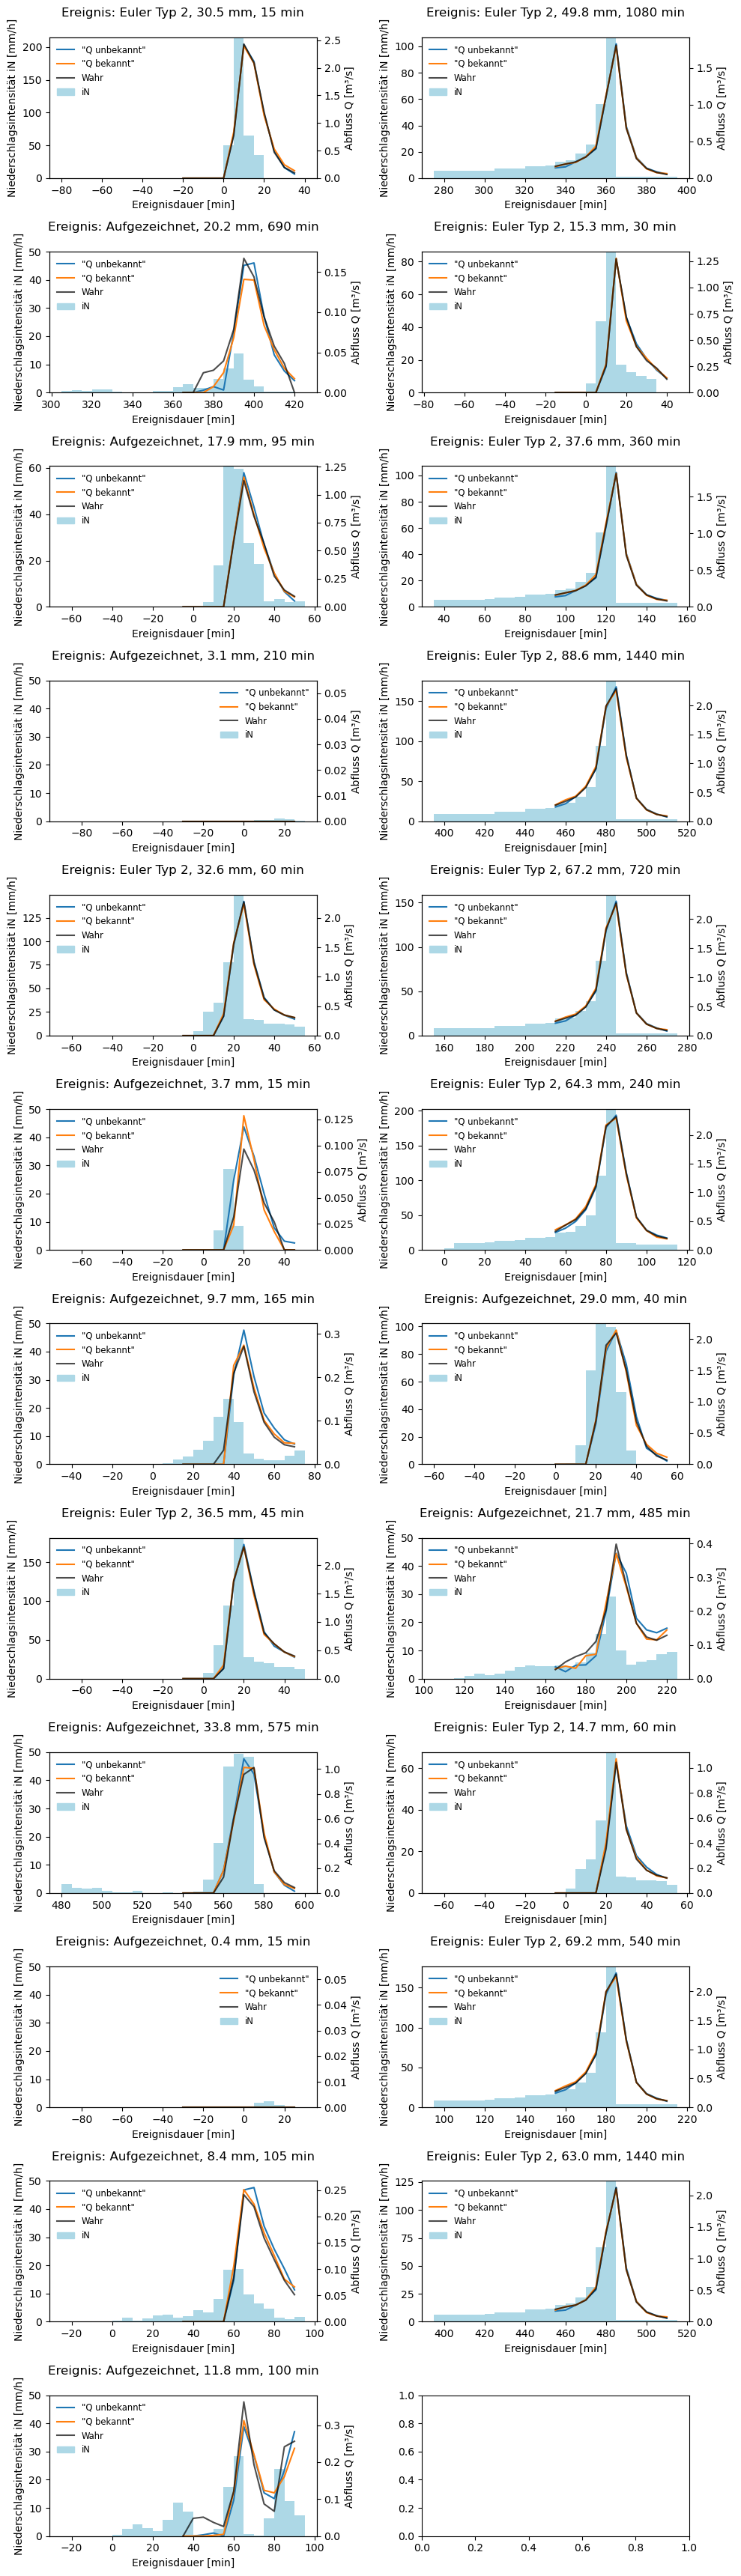

In [27]:
# Plot predict and plot the peak time steps of each event and calculate the peak metrics
#retrieve the interval of the time steps
interval = models[0]['seq_test'][0][0]['interval']
p_steps = models[0]['prediction_steps']
# set peak horizon = time difference between the peak and the start of the prediction
peak_horizon = 30 # in minutes


peak_horizon_steps = p_steps - int((peak_horizon) / interval) - 1
# Create a grid of subplots

abs_errors = [np.array([]) for _ in range(len(models))]
sqrt_errors = abs_errors.copy()
abs_prct_errors = abs_errors.copy()

abs_errors_T = abs_errors.copy()
sqrt_errors_T = abs_errors.copy()
abs_prct_errors_T = abs_errors.copy()
abs_dT = abs_errors.copy()

def add_dur(seq , event_id, n):
    start_time = max(seq_test[event_id][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    # Calculate the start and end time of the sequence so that a duration column can be created
    duration_col = np.arange(start_time, end_time, interval)

    actual_seq = np.column_stack((duration_col,seq))
    return actual_seq, duration_col, start_time, end_time

event_dicts = []
# Loop through n_sample
for event_id in range(len(seq_test_trans)):
    
    dict = {}
    # n = sequence index for the sequence containing the peak
    max_q = np.max(seq_test[event_id][2][:, :, 0])
    
    
    indices = np.where(seq_test[event_id][2][:, :, 0] == max_q)
    # indices[0] will give you the index in the first dimension
    n = indices[0][0] if len(indices[0]) > 0 else None
    first_max = n
    # print("first_max: ",n)
    len_max = len(indices[0])
    # print("event: ",event_id, " max_q: ",max_q," first_max: ",n," len_max: ",len_max)
    len_dif = len(seq_test[event_id][2]) - n

    # if len_max < p_steps:
    #     peak_horizon_steps_calc = len_max - peak_horizon_steps
        # peak_horizon_steps_calc = max(peak_horizon_steps_calc, 0)
    # else:
    peak_horizon_steps_calc = peak_horizon_steps
    # n = np.argmax(seq_test[event_id][2][:, 0, 0])
    n = n + peak_horizon_steps_calc
    n = n.astype(int)
    # if max(seq_test[event_id][2][:, 0, 0]) > 0:
        # n = -12
    # if n <= len(seq_test[event_id][2]):
    #     n = 0
    
    n= max(n, 0)
    n = min(n, len(seq_test[event_id][2])-1)
    # n = 11
    dict['n'] = n
    # print("event: ",event_id, " max_q: ",max_q," n: ",n," len_max: ",len_max, " first max: ", first_max)
    # print("index: ",n)
    # print("len event: ", len(seq_test[event_id][2]))
    actual_seq = seq_test[event_id][2][n]
    dict['actual_seq'], dict['duration_col'], dict['start_time'], dict['end_time'] = add_dur(actual_seq,event_id, n)
    # Dictionary of event meta data
    dict['meta'] = seq_test[event_id][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type

    i = 0
    for m in models:
        seq_test = m['seq_test']
        seq_test_trans = m['seq_test_trans']
        model = m['model']

        interval = seq_test[event_id][0]['interval']
        meta = seq_test[event_id][0]
        in_seq = seq_test[event_id][1][n]
        out_act = seq_test[event_id][2][n]

        # Predict the sequence
        Predict = model.predict(seq_test_trans[event_id][1], verbose=0)
        Predict_invert = out_scaler.inverse_transform(Predict)

        predict_seq = np.column_stack((dict['duration_col'],Predict_invert[n]))
        dict[m['print_name']] = predict_seq

        # Calculate the peak metrics time dependent
        argmax = np.argmax(dict['actual_seq'][:, 1])
        actual_max = dict['actual_seq'][argmax, 1]
        predict_max = predict_seq[argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors[i] = np.append(sqrt_errors[i], extreme_squared_error)
        abs_errors[i] = np.append(abs_errors[i], extreme_abs_error)
        epsilon = 0
        ape =extreme_abs_error / (actual_max + epsilon) * 100
        if np.isinf(ape) == False:
            abs_prct_errors[i] = np.append(abs_prct_errors[i], ape)

        # Calculate the peak metrics time independent
        argmax = np.argmax(dict['actual_seq'][:, 1])
        actual_max = dict['actual_seq'][argmax, 1]
        pred_argmax = np.argmax(predict_seq[:, 1])
        predict_max = predict_seq[pred_argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors_T[i] = np.append(sqrt_errors_T[i], extreme_squared_error)
        abs_errors_T[i] = np.append(abs_errors_T[i], extreme_abs_error)
        epsilon = 0
        ape =extreme_abs_error / (actual_max + epsilon) * 100
        if np.isinf(ape) == False:
            abs_prct_errors_T[i] = np.append(abs_prct_errors_T[i], ape)
        abs_dT[i] = np.append(abs_dT[i],abs(argmax - pred_argmax) * interval)
        i+=1

    event_dicts.append(dict)
    # else:
    #     event_dicts.append(None)
    

peak_maes = []
peak_rmses = []
peak_mapes = []
peak_maes_T = []
peak_rmses_T = []
peak_mapes_T = []
peak_dT = []

for i in range(len(abs_errors)):
    mae = np.mean(abs_errors[i])
    rmse = np.sqrt(np.mean(sqrt_errors[i]))
    ape = abs_prct_errors[i][~np.isnan(abs_prct_errors[i])]
    mape = np.mean(ape)
    peak_maes.append(round(mae,3))
    peak_rmses.append(round(rmse,3))
    peak_mapes.append(round(mape,1))

    mae_T = np.mean(abs_errors_T[i])
    rmse_T = np.sqrt(np.mean(sqrt_errors_T[i]))
    ape_T = abs_prct_errors_T[i][~np.isnan(abs_prct_errors_T[i])]
    mape_T = np.mean(ape_T)
    peak_maes_T.append(round(mae_T,3))
    peak_rmses_T.append(round(rmse_T,3))
    peak_mapes_T.append(round(mape_T,1))
    peak_dT.append(round(np.mean(abs_dT[i]),2))

peak_eval = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAE [' + out_unit + ']': peak_maes,
    'RMSE [' + out_unit + ']': peak_rmses,
    'MAPE [%]': peak_mapes
})

peak_eval_dT = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAEmax [' + out_unit + ']': peak_maes_T,
    'RMSEmax [' + out_unit + ']': peak_rmses_T,
    'MAPEmax [%]': peak_mapes_T,
    'dt [min]': peak_dT
})
display(Markdown('**Auswertung der Maximalwertabweichungen**'))
print(tabulate(peak_eval_dT, headers='keys', tablefmt='psql', showindex=False))

# display(Markdown('<br>**Auswertung der Maximalwertabweichungen zu gleicher Zeit**'))

# print(tabulate(peak_eval, headers='keys', tablefmt='psql', showindex=False))

display(Markdown('<br>**Darstellung aller Maximalwertvorhersagen**'))

plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))
# Plot the peaks of the events
for event_id, dict in zip(range(len(seq_test_trans)), event_dicts):

    if dict is not None:
        col_index = event_id % 2
        n = dict['n']
        meta = dict['meta']

        # Create Barplot of Precipitation
        ax1 = axs[event_id // 2, col_index]
        ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'],1)} mm, {meta['duration']} min", pad=20)
        x = seq_test[event_id][1][n][:,0]  # Set x-axis values
        ax1.bar(x, seq_test[event_id][1][n][:,1], color='lightblue', label='iN', width=interval, align='edge')
        top_lim = max(max(seq_test[event_id][1][n][:,1]), 50)
        ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
        ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
        ax1.set_xlabel('Ereignisdauer [min]')
        # ax1.legend(fontsize = 'small')
        # Create a twin axis on the right side
        # Plotting the predicted and actual values in the corresponding subplot
        ax2 = ax1.twinx()
        blue_patch = [mpatches.Patch(color='lightblue', label='iN')]
        for m in models:
            ax2.plot(dict[m['print_name']][:, 0], dict[m['print_name']][:, 1], label=m['print_name'])
        ax2.plot(dict['actual_seq'][:, 0], dict['actual_seq'][:, 1], color = 'black', label='Wahr', alpha=0.70)
        ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
        ax2.set_ylabel('Abfluss Q [' + out_unit + ']')
        plt.legend(fontsize = 'small')
        old_handles, labels = ax2.get_legend_handles_labels()
        plt.legend(handles=old_handles + blue_patch, fontsize = 'small', frameon=False)

plt.tight_layout()
# Show the plot
plt.show()